# Classifying Galaxies

* **Author:**

* **Date:**

* **Time spent on this assignment:**

*This assignment closely follows a tutorial at the Galaxy Zoo.  You are not allowed to look up that tutorial when completing this assignment.*

In [19]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import  jax
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import itertools
from IPython.display import HTML
import pickle
import datetime;datetime.datetime.now()
def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','math','FuncAnimation',
                       'HTML','itertools','pickle','testFunc','jnp','jax','jit']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    return

## Exercise 1: Machine Learning on Galaxies

* **List of collaborators:**

* **References you used in developing your code:**

In this assignment, we are going to learn how to automatically classify galaxies using a deep neural network. Our goal will be to take a picture of a galaxy and decide which category it falls into (disc, round, cigar shape, etc). 

We are going to get the pictures of our galaxies from the Sloan Digital Sky Survey and the labels from the Galaxy Zoo (where the public hand-categorizes the galaxies).  We will then write and train a neural network to do this classification. Our goal is to be at least 66% accuracy (one can do much better but it requires more work then is reasonable for this assignment). 

Let's start by reading in the data. Run the following command to download a copy of the data we'll need

In [23]:
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/dataG.pkl.gz

--2021-08-17 01:48:12--  https://courses.physics.illinois.edu/phys246/fa2020/code/dataG.pkl.gz
Resolving courses.physics.illinois.edu (courses.physics.illinois.edu)... 130.126.151.14
Connecting to courses.physics.illinois.edu (courses.physics.illinois.edu)|130.126.151.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84647509 (81M) [application/x-gzip]
Saving to: ‘dataG.pkl.gz.1’

dataG.pkl.gz.1      100%[===================>]  80.73M   136MB/s    in 0.6s    

2021-08-17 01:48:13 (136 MB/s) - ‘dataG.pkl.gz.1’ saved [84647509/84647509]



Now we'll unpack it to the format we need

In [24]:
%%time
import gzip
(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(gzip.open("dataG.pkl.gz",'rb'))

CPU times: user 2.02 s, sys: 447 ms, total: 2.46 s
Wall time: 2.47 s


here's what you now have:
* `train_images_raw` - images in the training set, shape: (17457, 69, 69, 1)
* `train_labels`     - labels that explain the image classification for the training set
* `test_images_raw`  - images for the test set, shape: (1940,69,69,1)
* `test_labels`      - labels that explain the image classification for the test set

### A Note on the data

The original data has 3 channels - g,r,i bands - while this dataset has only 1 (g). This set also only includes a subset of labels. 

You are welcome to do this assignment with the full channel set and see how well it does; you'll need to download the full data we've provided:
```python
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/data.pkl.zip
!unzip data.pkl.zip
(train_images_raw,train_labels,test_images_raw,test_labels) = pickle.load(open("data.pkl",'rb'))
```

and then change the reshape commands below. Feel free to reach out to us for help.

### a. Galaxies

Let's now examine this data a bit.  We are first going to look at the training data.  The training data is what you are going to use to teach your neural network.  The test data is to check how good we are doing after (possibly during) training.  We won't use it to train, though (this is to avoid overfitting; we want our neural network to learn how to classify galaxies but not memorize everything in the training set). 

We will start by plotting some of the galaxy images that we have loaded.  Do `plt.matshow(train_images_raw[0][:,:,0])` (This last `[:,:,0]` is because there are three layers to each of these galaxies and we just want to see the first layer. We've actually only included this first layer for you to save space, but if you want to use the full data this is necessary)

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [1]:
#plot me here!

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

You should see a galaxy.  Now, let's see what this galaxy should be classified as.  Go ahead and print out `train_labels[0]`.


<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [2]:
## print out the label

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

Note that it has a `1` in the second place.  This tells us that this is a smooth completely round galaxy. (the ordering is  [here](https://astronn.readthedocs.io/en/latest/galaxy10.html)).

```
Galaxy10 dataset (25753 images)
├── *0* Class 0 (3461 images): Disk, Face-on, No Spiral
├── *1* Class 1 (6997 images): Smooth, Completely round
├── *2* Class 2 (6292 images): Smooth, in-between round
├── Class 3 (394 images): Smooth, Cigar shaped
├── *3* Class 4 (3060 images): Disk, Edge-on, Rounded Bulge
├── Class 5 (17 images): Disk, Edge-on, Boxy Bulge
├── Class 6 (1089 images): Disk, Edge-on, No Bulge
├── *4* Class 7 (1932 images): Disk, Face-on, Tight Spiral
├── Class 8 (1466 images): Disk, Face-on, Medium Spiral
└── Class 9 (1045 images): Disk, Face-on, Loose Spiral
```
![Galaxy10 dataset](https://astronn.readthedocs.io/en/v1.0.1/_images/galaxy10_example.png)

We are going to use 5 sets, which are indicated with the `*#*`

Let's instead display the image and label for image 98. We see that instead this is a disk galaxy (*this might depend on the randomness used in splitting up the training set so we need to check again when we re-pickle*)

[1. 0. 0. 0. 0.]


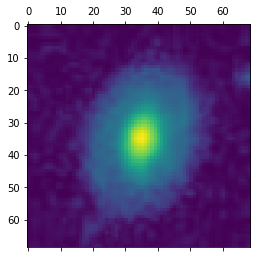

In [27]:
plt.matshow(train_images_raw[98][:,:,0])
print(train_labels[98])

Let's check the shape of our data.  Go ahead and print out `np.shape(train_images_raw))`

In [28]:
print(np.shape(train_images_raw))

(17457, 69, 69, 1)


We have 17457 images.  Each image is a $69 \times 69 \times 1$ image.  We are going to give these pictures as inputs to our neural network.  It will be easier to give them a big $69 \times 69 \times 1$ vector then a tensor like this.  Therefore, we should go ahead and reshape our data.  To do this, we can do `train_images=train_images_raw.reshape(len(train_images_raw),69*69*1)`  (Do the same thing for our `test_images_raw data`).  **You also need to normalize the image data so it's between 0 and 1.  To do that divide all your vectors by 256**

In [29]:
train_images = train_images_raw.reshape(len(train_images_raw),69*69*1)/256.
test_images  = test_images_raw.reshape(len(test_images_raw),69*69*1)/256.


We will work with these reshaped vectors for most the rest of this assignment. 




### b. Neural Network

---
#### <span style="color:red">Warning: Use ```jnp```!</span>
Notice that at the top of the file, we have imported ```jax.numpy as jnp``` alongside regular ```numpy as np```. To proceed with this assignment, you now need to start using ```jnp``` instead of ```np```. It's a drop-in replacement for all functions (```sum```, ```log```, etc.) that you'll normally use in numpy but is required for the fancy gradient calculations necessary for training your net.

---

Our next step is to write a neural network.   A neural network might sound complicated but it's actually really simple.  All our neural network does is take the input vector (our reshaped image) to an output vector (of size 5 because we have five different ways to classify a galaxy).  

The equation for how to do this is 
 $v_{out} = 1.0/(1+\exp(-(W_2 \textrm{tanh}(W_1 v_{in} + b_1) +b_2))$
where 
* W1 is a size d x 4761 matrix
* W2 is a size 5 x d matrix
* b1 is a size d x 1 matrix (the 1 is important -- use ```np.random.rand(d, 1)```)
* b2 is a size 5 x 1 matrix

The last term: $1/(1+e^{-x})$ ensures that all the numbers in $v_{out}$ are between 0 and 1.

To make this function work in parallel on multiple $v_{in}$'s simultaneously, you can just supply them as a big matrix $V_{in}$ (of size ```(17457, 4761)```) and add in some transpositions to make the matrix multiplication shapes work:

$$ v_{out} = \left(1+\exp\left[-\left(\left[W_2 \cdot \mathrm{tanh}(W_1 \cdot V_{in}^\top + b_1)\right] +b_2\right)\right]\right)^{-1} $$


Implement a function 
```python
def net(params,imageVector):
   # W1=params[0]
   # b1=params[1]
   # W2= params[2]
   # b2 = params[3]
   # return output
```
where params is a list that contains these parameters and imageVector is one of our reshaped images. 


Let's test this out.  Generate a set of random parameters that have the correct dimension (for example to do this I used `0.1*np.random.randn(5,d)` for W2).   Then call `net(params,train_images[3])` and you should get what your current neural network guesses is the classification for the "3'rd" galaxy.  Use $d=100$.


<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

Notice that the output isn't a nice vector like `[0,0,0,0,1]`. Instead, it has five different numbers between zero and one such as `[0.2400989 , 0.39862376, 0.4565858 , 0.286503  , 0.734855  ]`  We will say that the neural network classifies the galaxy by whichever index is largest i.e. `np.argmax(outputVector)`. In this case it is the 0.8866 which corresponds to spot 4 or "Disk Edge on- rounded bulge" category.  

### c. A measure of goodness

To quantify how good our neural network is, we will use two things: 

(1) **Cross-entropy**
Let's quantify how far off you are from the expected label (maybe it's `[0,0,0,1,0]`) . A good way to quantify this is to use the cross entropy.  The cross-entropy is defined as 

$$ \sum_i -y_i \log(a_i) - (1-y_i)\log(1-a_i)$$

where $y_i$ is the $i'$th component of the exact label and $a_i$ is the $i'$th component of the label you get as output from the neural network.  

Write a function 
`loss(params, imageVector, correctLabel)` that takes the parameters and the `imageVector`, runs the neural network to get the output `a` (i.e. `a=net(params,imageVector)`) and then returns the cross entropy.  Check the cross entropy you are getting. Our goal will be to minimize this cross entropy (if we do this, then our network will do a better job of getting the correct galaxy classification)


<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
##

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

(2) **Correct classification** 
In addition to the cross-entropy, we care whether the winning labelling is correct. We will say that we've labelled it correctly if in our length 10 vector, the maximum value is where the 1 should be.  Write a function `def fractionCorrect(params,images,labels)` that says what fraction you got correct. (`np.argmax` is probably useful here).  Run this on your test images and labels.

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
###

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

You probably got about 30% correct with your random values of `w1,b1,w2,b2`. Now we have to do better.  We are going to work on getting our loss down (and this will get our fractionCorrect down).  Getting the loss down is easier because it depends continuously on the parameters).  

To make an objective function better, what we should do is to step in a direction where it gets better.  To do this, we are going to want to get the gradient.  We can use jax to get the gradient as we have in earlier assignments.  

Let's define the gradient of the loss as 
`loss_grad = jit(jax.grad(jit(loss)))`.  (The `jit` are there to make things faster.  This is morally just `jax.grad(loss)` and that would work albeit be slower).  



### d. Classification

Now all we need to do is to (over and over again)
* choose a random image in the **training** set.
* compute the gradient
* change the parameters by 0.1% of the gradient (called the *learning rate* $\eta$)

This will make your result on this image marginally better. 

Every 2000 steps you might want to check the fraction of your test set that is now correct. Print it out as well as push it to a list.  You should find that your accuracy rises from 30% beyond 66%.  Plot your accuracy as a function of step for at least 50\*2000, and if patient out to 100\*2000. 

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
##

Explore a couple images and see how the your neural network classifies it.  Also, it might be fun to go ahead and look at the ones that it classifies incorrectly whether its second choice was correct.  You can go ahead and explictily check this by looping over everything and collecting some statistics. 

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (start)"></img><br></div>

We computed the gradient and took a step after every image.  It is better to average the gradient over some number (say ten) images and then take a step.  This is called a mini-batch.  Write some code to do mini-batches by just looping over ten images.  Then improve your code by figuring out to remove the extra loop and use `jax.vmap`

### e.  Mini-batches and vmap (Extra Credit: 5 points)

**Acknowledgement:** This assignment follows very closely a tutorial from GalaxyZoo.com
* Bryan Clark and Ruyan Level (original)


Copyright: 2021

---